# **Test de imagen y vídeo**

Estas celdas pone a prueba el *core* y algunos bloques de la librería.

Funciona en la versión 0.1.19, pero más allá puede que no.

Los submódulos **core** y **blocks** aún no están *congelados*.

---

**ATENCIÓN**: La celda del vídeo es (muy) lenta si la usas en Colab. Incluso con un kernel con GPU. Usa un servidor jupyter local.



In [ ]:
# https://mediapipe-studio.webapps.google.com/home

!pip -q install ml4teens==0.1.20

In [13]:
import warnings;

warnings.filterwarnings('ignore');

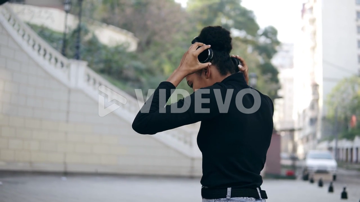

In [14]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource(speed=0.5);
pantalla = ml.blocks.Display(width=360);

vídeo["frame"] >> pantalla["image"];

context.emit(target=vídeo, sname="source", data="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc3022971d79.05815712_FPpreview.mp4");
context.wait(boredtime=1);


In [15]:
import PIL;
import torch;

from PIL.Image import Image;

from transformers import DPTImageProcessor, DPTForDepthEstimation;

import numpy as np;

from ml4teens.core import Block;

class DepthEstimation(Block):

      def __init__(self, **kwargs):
          super().__init__(**kwargs);
          self.processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
          self.model     = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

      #-------------------------------------------------------------------------
      @Block.slot("image", {Image}, required=True)
      def slot_image(self, slot, data):
          inputs = self.processor(images=data, return_tensors="pt");

          with torch.no_grad():
              outputs = self.model(**inputs);
              predicted_depth = outputs.predicted_depth;

          prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1), size=data.size[::-1], mode="bicubic", align_corners=False);

          output = prediction.squeeze().cpu().numpy();
          formatted = (output * 255 / np.max(output)).astype("uint8");
          imagen = PIL.Image.fromarray(formatted);

          self.signal_image(imagen);

      #-------------------------------------------------------------------------
      @Block.signal("image", Image)
      def signal_image(self, data):
          return data;


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


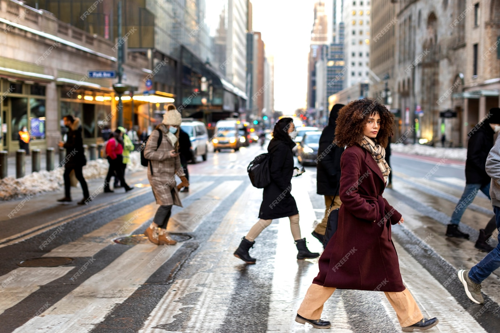

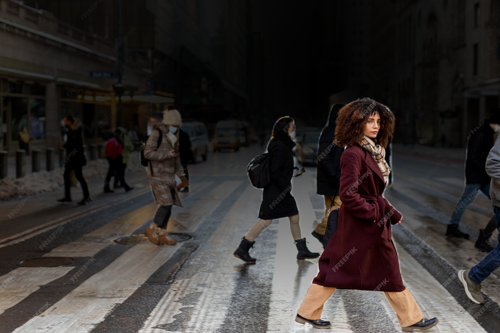

In [16]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
split    = ml.blocks.SplitChannels();
merge    = ml.blocks.MergeChannels();
depth    = DepthEstimation();
opsR     = ml.blocks.ImageOp(op="eval", expression="convert((float(r)/255)*l,'L')");
opsG     = ml.blocks.ImageOp(op="eval", expression="convert((float(r)/255)*l,'L')");
opsB     = ml.blocks.ImageOp(op="eval", expression="convert((float(r)/255)*l,'L')");
salida   = ml.blocks.Display(width=500, feed=True);

imagen["image"] >> split ["image"];
imagen["image"] >> depth ["image"];
imagen["image"] >> salida["image"];

depth ["image"] >> opsR ["left"];
depth ["image"] >> opsG ["left"];
depth ["image"] >> opsB ["left"];

split["red"   ] >> opsR ["right"]
split["green" ] >> opsG ["right"]
split["blue"  ] >> opsB ["right"]

opsR ["image" ] >> merge["red"  ]
opsG ["image" ] >> merge["green"]
opsB ["image" ] >> merge["blue" ]

merge["image"] >> salida["image"];

#source="https://img.freepik.com/foto-gratis/mujer-tiro-completo-bicicleta-al-aire-libre_23-2149413735.jpg?w=1380&t=st=1704297833~exp=1704298433~hmac=433c68f72fc841cbb094d598521f8b72dad100a383f59b39de5f490cce7c7b99";
source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen, sname="source", data=source);
context.wait(boredtime=1);



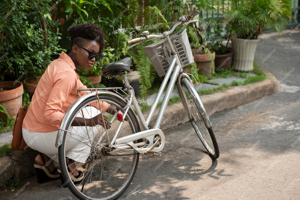

In [17]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
img2text = ml.blocks.ImageToText(caption="A photo of an");
terminal = ml.blocks.Terminal();
salida   = ml.blocks.Display(width=300);

imagen  ["image"] >> img2text["image" ];
imagen  ["image"] >> salida  ["image" ];
img2text["text" ] >> terminal["stdout"];

source="https://img.freepik.com/foto-gratis/mujer-tiro-completo-bicicleta-al-aire-libre_23-2149413735.jpg?w=1380&t=st=1704297833~exp=1704298433~hmac=433c68f72fc841cbb094d598521f8b72dad100a383f59b39de5f490cce7c7b99";
#source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen, sname="source", data=source);
context.wait(boredtime=1);


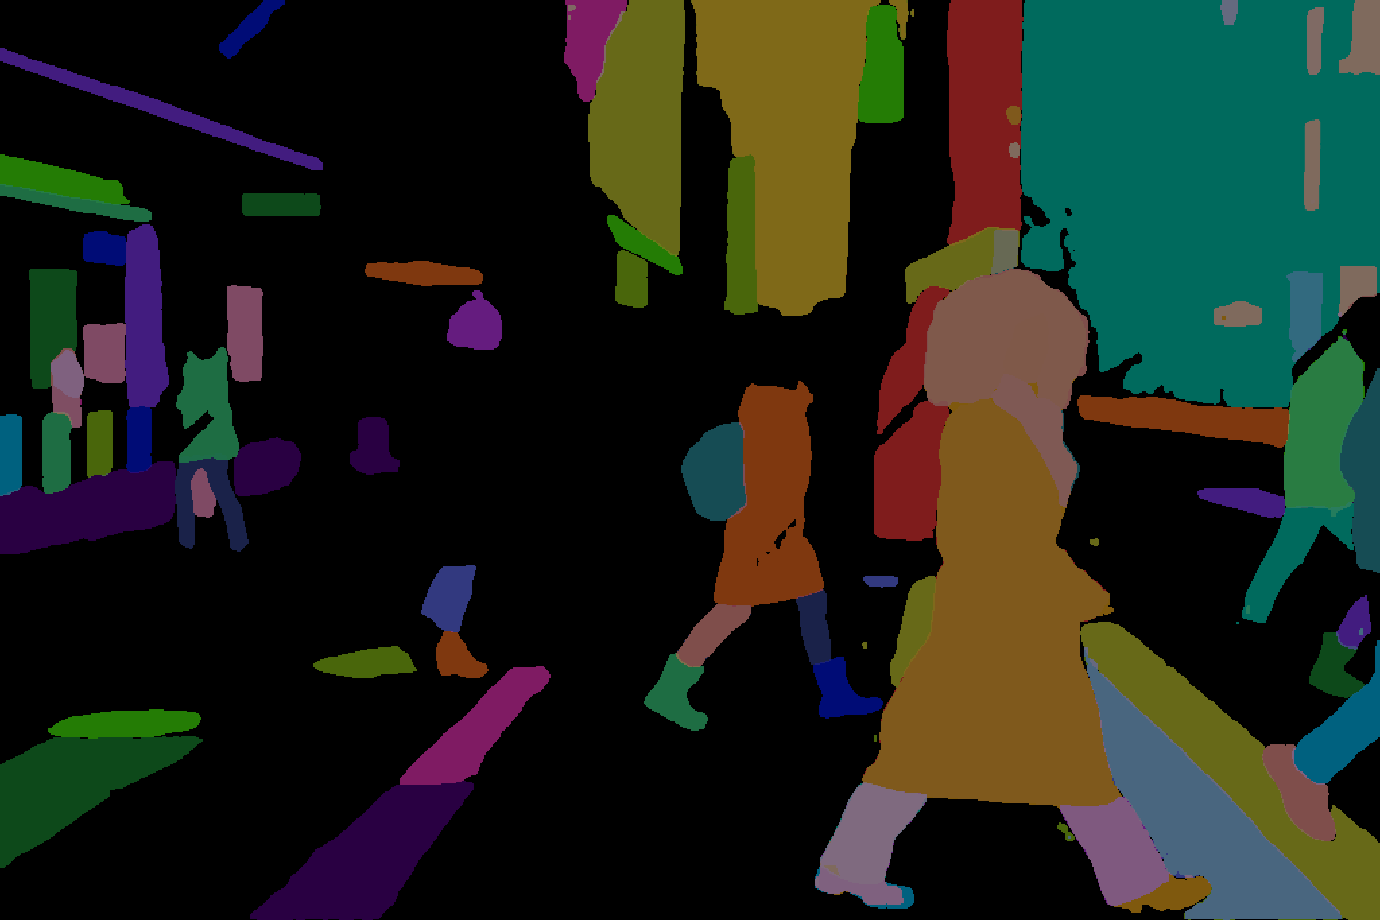

In [9]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
imgseg   = ml.blocks.ImageSegmentAll(model_name="s");
salida   = ml.blocks.Display();

imagen["image"] >> imgseg["image"];
imgseg["mask" ] >> salida["image"];

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen, sname="source", data=source);
context.wait(boredtime=1);


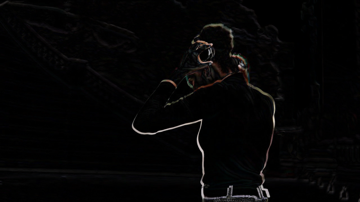

In [8]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource();
op       = ml.blocks.ImageOp(op="diff seq");
salida   = ml.blocks.Display(feed=False, width=360, sped=0.5);
#
vídeo ["frame"] >> op    ["image"];
op    ["image"] >> salida["image"];

#source="https://v4.cdnpk.net/videvo_files/video/free/video0482/large_watermarked/_import_62bbefe51f3547.77164811_FPpreview.mp4";
source="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc3022971d79.05815712_FPpreview.mp4";

context.emit(target=vídeo, sname="source", data=source);
context.wait(boredtime=1);


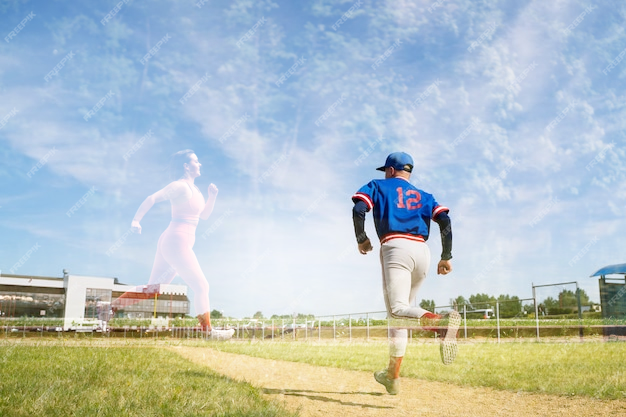

In [7]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

image_left  = ml.blocks.ImageSource();
image_right = ml.blocks.ImageSource();
op          = ml.blocks.ImageOp(op="screen");
salida      = ml.blocks.Display();

image_left ["image"] >> op    ["left" ];
image_right["image"] >> op    ["right"];
op         ["image"] >> salida["image"];

source_left  = "https://img.freepik.com/foto-gratis/mujer-tiro-completo-corriendo-al-aire-libre_23-2149622958.jpg?w=1380&t=st=1704273288~exp=1704273888~hmac=7b34946ecff9d06c9fef1f159d2bdb54361e355eb7c34648b1b153b0cb4a84f7";
source_right = "https://img.freepik.com/foto-gratis/nino-vista-lateral-corriendo-campo_23-2149457304.jpg?t=st=1704273288~exp=1704273888~hmac=7e375feb2153c63c38aed1e5a4bd467c2210a61c6500f14e806299094f57e0dc";

context.emit(target=image_left,  sname="source", data=source_left);
context.emit(target=image_right, sname="source", data=source_right);
context.wait(boredtime=1);



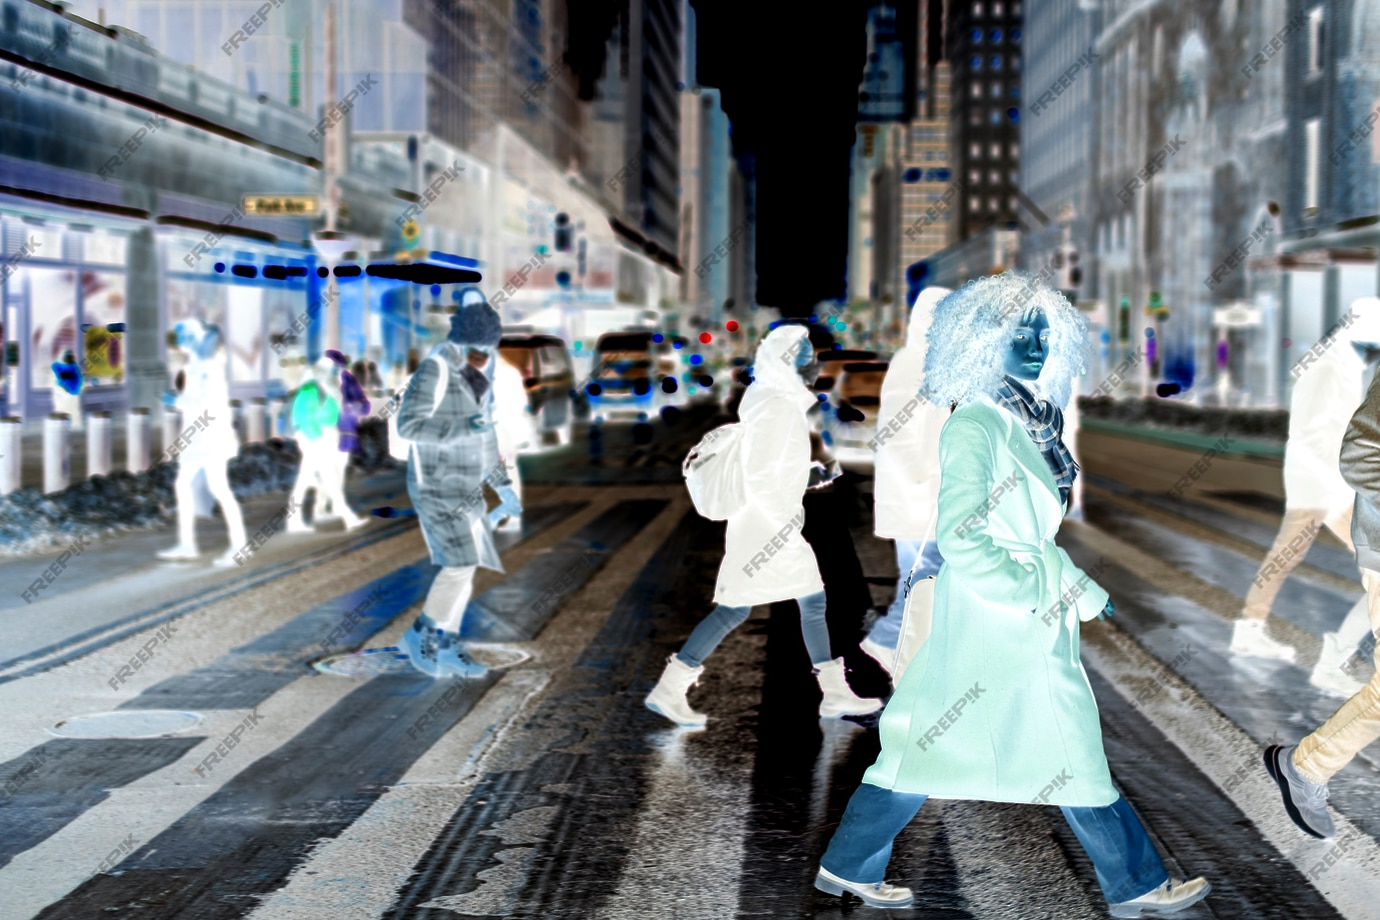

In [6]:
from ml4teens.tools import debug;
debug.disable();

import sys, traceback;

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
op       = ml.blocks.ImageOp(op="invert");
salida   = ml.blocks.Display();

imagen["image"] >> op    ["image"];
op    ["image"] >> salida["image"];

source = "https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen,  sname="source", data=source);
context.wait(boredtime=1);


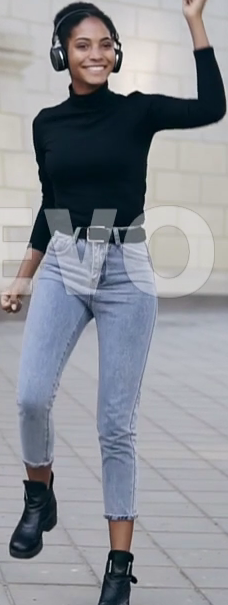

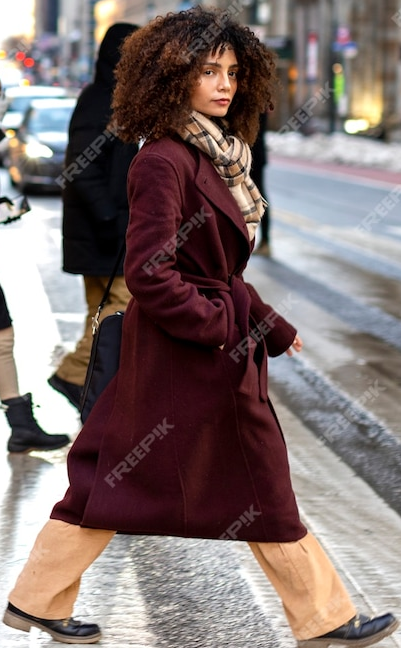

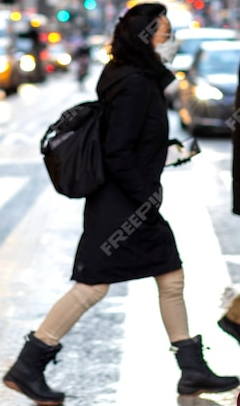

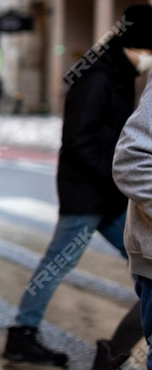

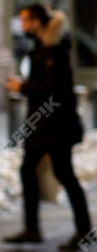

In [5]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
objid    = ml.blocks.ObjectID(model_name="l");
cropi    = ml.blocks.CropImage(conf=0.85, classes=[0]);
salida   = ml.blocks.Display(feed=True);

imagen["image"] >> objid ["image"];
imagen["image"] >> cropi ["image"];
objid ["boxes"] >> cropi ["boxes"];
cropi ["image"] >> salida["image"];

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307"

context.emit(target=imagen,  sname="source", data=source);
context.wait(boredtime=1);


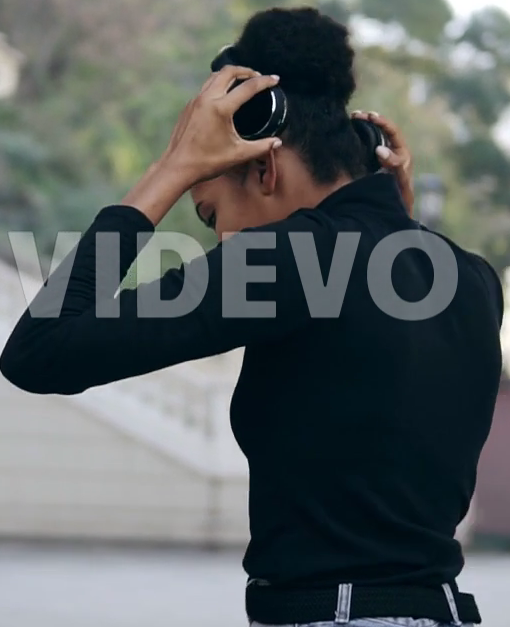

In [18]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource(speed=1.5);
objid    = ml.blocks.ObjectID(model_name="xs");
cropi    = ml.blocks.CropImage(n=1);
salida   = ml.blocks.Display(feed=False);

vídeo ["frame"] >> objid ["image"];
vídeo ["frame"] >> cropi ["image"];
objid ["boxes"] >> cropi ["boxes"];
cropi ["image"] >> salida["image"];

#source="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc2f69bd3275.18895086_FPpreview.mp4";
source="https://v4.cdnpk.net/videvo_files/video/free/video0460/large_watermarked/_import_60cc3022971d79.05815712_FPpreview.mp4";

context.emit(target=vídeo, sname="source", data=source);
context.wait(boredtime=1);


In [20]:
import gc;

gc.collect();

## Vídeo al que se le ajusta el tamaño según el tamaño de una imagen exterior.

La siguiente celda muestra cómo podemos tener más de un punto de inicio.

**Observar**: se ejecutan (context.run) varios bloques, primero 'imagen' (que establece el shape que ha de tener el vídeo) y luego 'vídeo'.

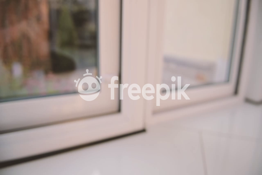

In [21]:
from ml4teens.tools import debug;
debug.disable();

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource(height=175);
vídeo    = ml.blocks.VideoSource(speed=0.5);
resize   = ml.blocks.ResizeImage(height=500);
salida   = ml.blocks.Display(feed=False);

imagen["image"] >> resize["shape":];
vídeo ["frame"] >> resize["image"];
resize["image"] >> salida["image"];

source_imagen = "https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";
source_vídeo  = "https://v5.cdnpk.net/videvo_files/video/premium/partners0817/large_watermarked/h8caae9f6_V0027_049_B_FPpreview.mp4";

context.emit(target=vídeo,  sname="source", data=source_vídeo);
context.emit(target=imagen, sname="source", data=source_imagen);
context.wait();



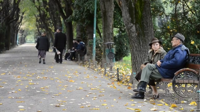

In [22]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource();
resize   = ml.blocks.ResizeImage(width=200);
salida   = ml.blocks.Display();

vídeo ["frame"] >> resize["image"];
resize["image"] >> salida["image"];

source="https://cdn.pixabay.com/vimeo/188704568/parque-6096.mp4?width=640&hash=112e5fd94cb9090c07f4472a41d182d344db647b";

context.emit(target=vídeo,  sname="source", data=source);
context.wait();



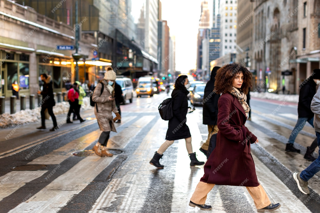

In [23]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
split    = ml.blocks.SplitChannels();
merge    = ml.blocks.MergeChannels();
salida   = ml.blocks.Display(width=320, feed=True);

imagen["image"] >> split["image"];

split["red"]   >> merge["red"];
split["green"] >> merge["green"];
split["blue"]  >> merge["blue"];

merge["image"] >> salida["image"];

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307"

context.emit(target=imagen,  sname="source", data=source);
context.wait();


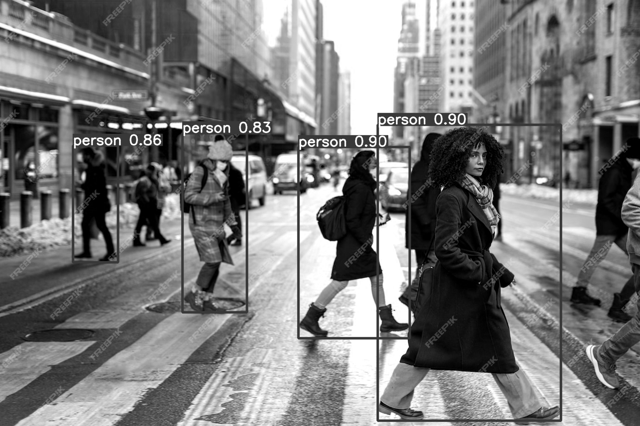

In [24]:
import sys, traceback;

import ml4teens as ml;

context   = ml.core.Context.instance.reset();

imagen   = ml.blocks.ImageSource();
objid    = ml.blocks.ObjectID(model_name="xs", conf=0.80);
grey     = ml.blocks.SingleChannel(channel=2);
salida   = ml.blocks.Display(width=640);
terminal = ml.blocks.Terminal();

((imagen["image"] >> objid["image"])["image"] >> grey["image"])["image"]>> salida["image"];

objid["boxes"] >> terminal["stdout"];

source="https://img.freepik.com/foto-gratis/mujer-joven-ciudad-nueva-york-dia_23-2149488509.jpg?w=1380&t=st=1703867123~exp=1703867723~hmac=20196a7ae65904ba1c28259dfc56a7a7419943edb163eee94f92f7dda0ad8307";

context.emit(target=imagen,  sname="source", data=source);
context.wait();



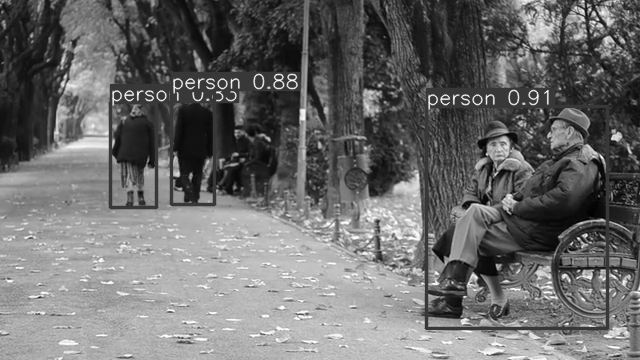

In [25]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource();
grey     = ml.blocks.SingleChannel(channel=1);
objid    = ml.blocks.ObjectID(model_name="xs", conf=0.60);
salida   = ml.blocks.Display(width=640);

((vídeo["frame"] >> objid["image"])["image"] >> grey["image"])["image"] >> salida["image"];

source="https://cdn.pixabay.com/vimeo/188704568/parque-6096.mp4?width=640&hash=112e5fd94cb9090c07f4472a41d182d344db647b";

context.emit(target=vídeo,  sname="source", data=source);
context.wait();


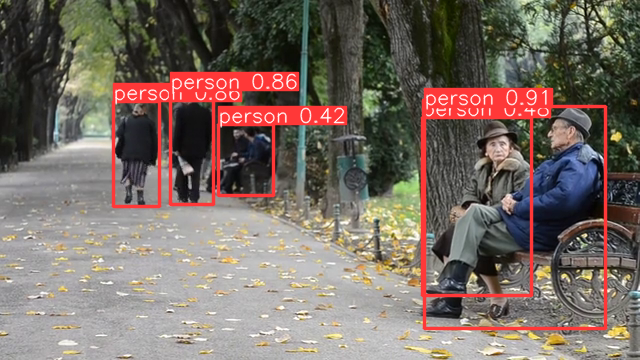

In [26]:
import ml4teens as ml;

context   = ml.core.Context.instance.reset();

vídeo    = ml.blocks.VideoSource();
objid    = ml.blocks.ObjectID(model_name="xs");
salida   = ml.blocks.Display(width=640);

vídeo["frame"] >> objid["image"];
objid["image"] >> salida["image"];

source="https://cdn.pixabay.com/vimeo/188704568/parque-6096.mp4?width=640&hash=112e5fd94cb9090c07f4472a41d182d344db647b"

context.emit(target=vídeo,  sname="source", data=source);
context.wait();
